In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [24]:
# Read the matching results csv file
dfl = pd.read_csv('depth_loss.csv')
dfnl = pd.read_csv('no_depth_loss.csv')

# rename the # basename column to basename
dfl.rename(columns={'# basename': 'basename'}, inplace=True)
dfnl.rename(columns={'# basename': 'basename'}, inplace=True)
dfnl.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 295 entries, 0 to 294
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   basename  295 non-null    int64  
 1   x_pred    295 non-null    float64
 2   y_pred    295 non-null    float64
 3   x_gt      295 non-null    int64  
 4   y_gt      295 non-null    int64  
dtypes: float64(2), int64(3)
memory usage: 11.6 KB


In [26]:
# compute l1 distance between the ground truth and the predicted bounding box
dfnl['l1_distance'] = dfnl.apply(lambda row: abs(row['x_gt'] - row['x_pred']) + abs(row['y_gt'] - row['y_pred']), axis=1)
# compute distance on x-axis between the ground truth and the predicted bounding box
dfnl['x_distance'] = dfnl.apply(lambda row: abs(row['x_gt'] - row['x_pred']), axis=1)

# compute l1 distance between the ground truth and the predicted bounding box
dfl['l1_distance'] = dfl.apply(lambda row: abs(row['x_gt'] - row['x_pred']) + abs(row['y_gt'] - row['y_pred']), axis=1)
# compute distance on x-axis between the ground truth and the predicted bounding box
dfl['x_distance'] = dfl.apply(lambda row: abs(row['x_gt'] - row['x_pred']), axis=1)

/home/romain/anaconda3/envs/TX/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/romain/anaconda3/envs/TX/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/romain/anaconda3/envs/TX/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/romain/anaconda3/envs/TX/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version

Text(0, 0.5, 'density')

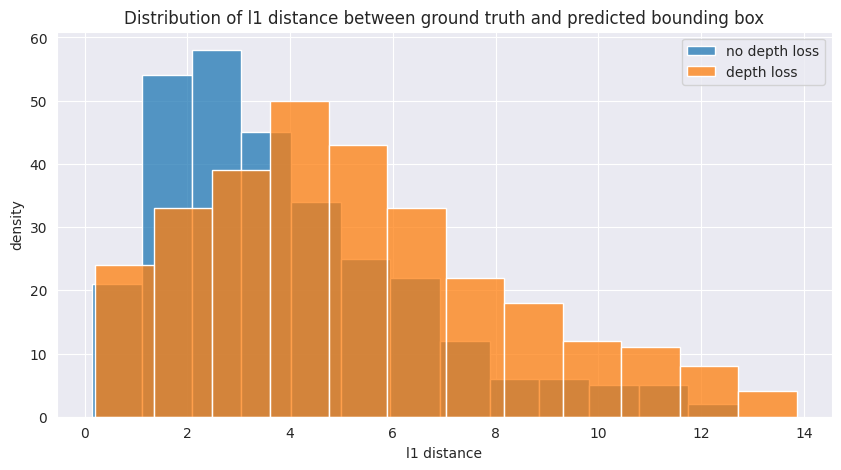

In [30]:
# plot the distribution of l1 distance using seaborn on the no depth loss model and the depth loss model
plt.figure(figsize=(10, 5))
sns.histplot(dfnl['l1_distance'], label='no depth loss')
sns.histplot(dfl['l1_distance'], label='depth loss')
plt.legend()
plt.title('Distribution of l1 distance between ground truth and predicted bounding box')
plt.xlabel('l1 distance')
plt.ylabel('density')

Text(0, 0.5, 'y_gt')

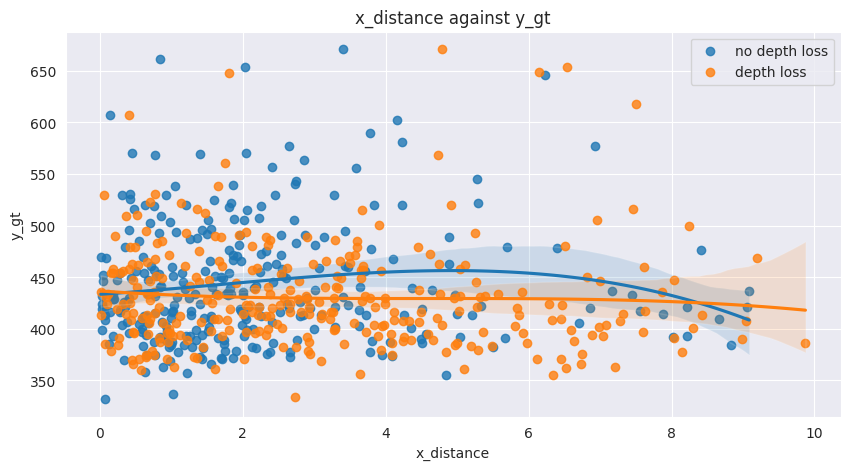

In [34]:
# Plot the x_distance against y_gt using seaborn
# draw a trend line it can be a polynomial regression for no depth loss model and depth loss model
plt.figure(figsize=(10, 5))
sns.regplot(data=dfnl, x='x_distance', y='y_gt', label='no depth loss', order=3)
sns.regplot(data=dfl, x='x_distance', y='y_gt', label='depth loss', order = 3)
plt.legend()
plt.title('x_distance against y_gt')
plt.xlabel('x_distance')
plt.ylabel('y_gt')

/home/romain/anaconda3/envs/TX/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/romain/anaconda3/envs/TX/lib/python3.9/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


<AxesSubplot:xlabel='y_gt_bin', ylabel='x_distance'>

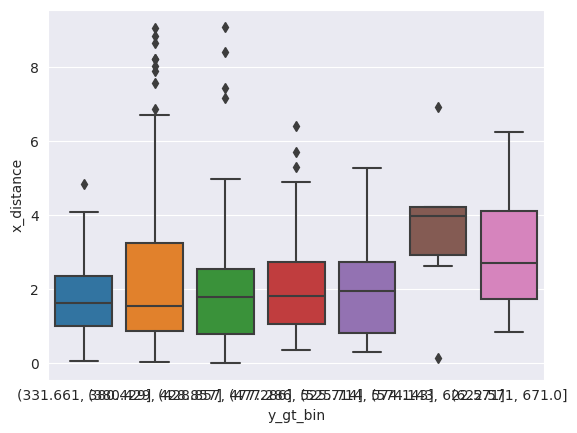

In [52]:
# Plot boxplot of x_distance against y_gt in 10 bins
dfnl['y_gt_bin'] = pd.cut(dfnl['y_gt'], bins=7)
sns.boxplot(x='y_gt_bin', y='x_distance', data=dfnl)

/home/romain/anaconda3/envs/TX/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/romain/anaconda3/envs/TX/lib/python3.9/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


<AxesSubplot:xlabel='y_gt_bin', ylabel='x_distance'>

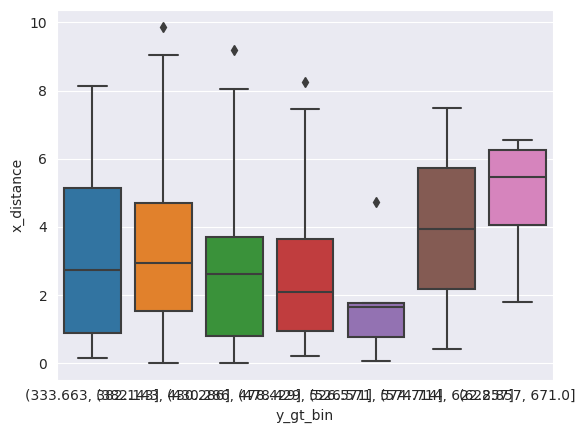

In [50]:
dfl['y_gt_bin'] = pd.cut(dfl['y_gt'], bins=7)
sns.boxplot(x='y_gt_bin', y='x_distance', data=dfl)